# Implémentation de résolution d'EDO à l'aide de réseaux de neurones

Ici nous nous proposons d'utiliser la méthode Lagaris pour résoudre des EDO

In [ ]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import autograd.numpy.random as npr
from autograd import grad
#Importons les éléments de différentiation essentiels à notre réseau de neurones
from scipy.integrate import solve_ivp
#la méthode d'intégration pour obtenir résoudre nos EDO

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import seaborn as sns
sns.set()
#Pour des beaux graphiques

On définit la fonction f de l'edo tel que 
$$\frac{dy(t)}{dt}=f(t,y)$$

Définissons aussi 
$$
G\Big(y,\frac{dy}{dt},t\Big) = \frac{dy(t)}{dt}-f(t,y) =0
$$

In [ ]:
def f(t, y):
    return np.array([t*(998*y[0] + 1998*y[1]), -999*y[0] - 1999*y[1]])
"""def f_ivp(t,y):
  return [t*(998*y[0] + 1998*y[1]), -999*y[0] - 1999*y[1]]
"""
t = np.linspace(0,2,11)

y0=[2,-1]
sol = solve_ivp(f, [t.min(), t.max()], y0, method='RK45', rtol=1e-5)
#Calcul de la solution réelle grâce à la méthode RKF45 (equivalent à RKF45 sur matlab)

Voilà à quoi pourrait ressembler la solution par la méthode de RK45:

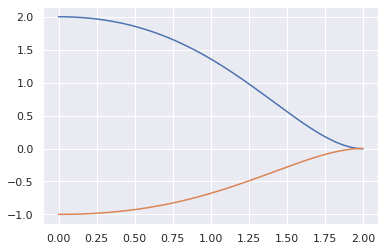

In [ ]:
plt.plot(sol.t,sol.y.T)

Définissons aussi la fonction de scale qui aura le role suivant dans notre réseau: Soit $\hat{y}$ la solution de notre réseau:
$$\hat{y}(t)=y_0+a(t)N(t,p), \quad a(t_0) = 0$$

Ainsi que $b$ qui sert au calcul de l'erreur. Dans l'article de [Flamant *et al.*](https://arxiv.org/pdf/2006.14372.pdf), on calcul l'erreur comme étant:
$$
L = \frac{1}{\lvert B \rvert} \sum_{(t,x_{0})\in B} b(t_i) \lvert G\Big(\hat{y}(t_i,x_{0}), \frac{\hat{y}(t_i,x_{0})}{\partial t},t_i \Big) \rvert ^2
$$
$b$ sert à augmenter la vitesse à laquelle le réseau s'entraîne.
Notons qu'il s'agit ici d'une adaptation de la loss qui est utilisée dans l'article. Nous considérons la loss pour un exemple de paramètres de fonction donnée, alors que dans l'article en lui même, on ajoute tout un intervalle de points de départs, ainsi que des paramètres de l'équation différentielle prise en compte.


In [ ]:
def a(t,t0=0):
    return 1-np.exp(-(t-t0))

def b(t,t0=0):
  return np.exp(-(t-t0))


Commencons par définir notre réseau de neurones:

Dans l'implémentation choisie, on suppose que `layer_size` est un array qui définit le nombre d'entrées, de sorties ainsi que le nombre de neurones de chaque couches.

Dans l'example pour lequel j'ai appliqué l'entraînement de mon réseau, j'ai une entrée par point d'apprentissage, et deux sorties. J'ai donc ensuite l'option du nombre de neurones par couches cachées. Notons donc qu'un réseau de neurones donné sera entièrement définit par ses paramètres.


Ici la fonction forward calcul, pour un set de paramètres, une entrée et une fonction d'activation, l'évaluation du réseau de neurones.

In [ ]:
def init_params(layer_sizes):
    return [(.5*npr.randn(m,n),
             .5*npr.randn(n))
             for m,n in zip(layer_sizes[:-1],layer_sizes[1:])]

def forward(input,parametres, act=np.tanh):
    input=input.reshape(-1,1)
    for poids, biais in parametres:
        out=np.dot(input,poids)+biais
        input=act(out)
    return out

Maintenant la solution de l'EDO par la méthode de Lagaris ainsi qu'un wrapper des dérivées:

Ici, la fonction `lagaris` est simplement la fonction décrite ci-dessus, ainsi que dans l'article de [Lagaris *et al.*](https://arxiv.org/pdf/physics/9705023.pdf)

Et la fonction qui suit est la même mais nous donne la $i^{ème}$ composante de l'évaluation de la solution pour le réseau de neurones.

In [ ]:
def lagaris(t,y0,parametres,a=a,act=np.tanh):
    t.reshape(-1,1);
    sortie=y0+a(t).reshape(-1,1)*forward(t,parametres,act)
    return sortie.T
def lagarisi(t,y0,parametres,i,a=a,act=np.tanh):
  return lagaris(t,y0,parametres,a=a,act=np.tanh)[i]

Ici, on définit `gradlagaris` qui est simplement la dérivée de la sortie par rapport au paramètre d'entrée, dans notre cas $t$

In [ ]:
gradlagarisi=egrad(lagarisi)

Enfin définissons la fonction de coût qui va nous servir à optimiser notre réseau de neurones
Ici, il s'agit simplement de la fonction de coût donnée plus haut: 
$$
L = \frac{1}{\lvert B \rvert} \sum_{(t,x_{0})\in B} b(t_i) \lvert G\Big(\hat{y}(t_i,x_{0}), \frac{\hat{y}(t_i,x_{0})}{\partial t},t_i \Big) \rvert ^2
$$

In [ ]:
def cost(input,y0,parametres,f=f,a=a,act=np.tanh):
  #D'abord on prend les dérivations par rapport à t des y_i
  preds=np.array([gradlagarisi(t,y0,parametres,i) for i in range(len(y0))])
  #Ensuite on regarde les valeurs exactes que les dérivées sont sensé respecter
  exact=np.array(f(t,lagaris(t,y0,parametres)))
  #On prend le carré de la différence sur l'erreur en chaque y_i
  diffpred=b(t)*(preds-exact)**2
  #On prend l'erreur sur tout les examples pris pour apprendre
  err_y_i = np.sum(diffpred,axis=0)
  #On retourne l'erreur totale qui est la somme des erreurs sur les deux sorties
  err_tot = np.mean(err_y_i)
  return err_tot

Ainsi qu'un test d'implémentation pour des paramètres pris au hasard avec 2 couches cachées de 10 neurones chacuns:

In [ ]:
parametres = init_params([1,10,10,2])
print(cost(t,y0,parametres))

"""preds=np.array([gradlagarisi(t,y0,parametres,i) for i in range(len(y0))])
exact=np.array(f(t,lagaris(t,y0,parametres)))
diffpred=b(t)*(preds-exact)**2
err_y_i = np.sum(diffpred,axis=0)
err_tot = np.mean(err_y_i)
print(err_tot)"""

3398272.2543958216


'preds=np.array([gradlagarisi(t,y0,parametres,i) for i in range(len(y0))])\nexact=np.array(f(t,lagaris(t,y0,parametres)))\ndiffpred=b(t)*(preds-exact)**2\nerr_y_i = np.sum(diffpred,axis=0)\nerr_tot = np.mean(err_y_i)\nprint(err_tot)'

Dans la suite, il nous est nécessaire de définir un wrapper de la loss pour utiliser la fonction `adam` de la bibliothèque [autograd](https://github.com/HIPS/autograd)

In [ ]:
#Normalement on définirait la loss pour un temps ainsi que des conditions initiales définies dans une classe 
#qui aurait été notre réseau de neurones. Ca n'est pas le cas ici, on suppose donc que la loss est toujours sur le même 
#intervalle. Il s'agit donc d'un simple wrapper de la fonction cost.
def loss(parametres,iter):
  return cost(t,y0,parametres,f,a,np.tanh)

Ainsi qu'un test de l'implémentation de celui-ci:

In [ ]:
print(loss(parametres,_))

3398272.2543958216


Définissons ensuite les paramètres et regardons comment notre réseau de neurones se débrouille: La réponse est mal. C'est normal étant donné que l'on ne l'a pas encore entraîné !

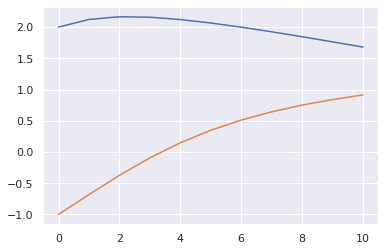

In [ ]:
params=init_params([1,10,10,2])
params2=init_params([1,10,10,2])

t=np.linspace(0,2,11)
y0=[2,-1]
plt.plot(lagaris(t,y0,params).T)

In [ ]:
from autograd.misc.optimizers import adam
#L'optimiseur qu'on utilise

On utilise ici l'optimiseur Adam décrit dans [Kingma *et al.*](https://arxiv.org/pdf/1412.6980.pdf). Voilà comment elle est implémentée dans la bibliothèque autograd: [adam](https://github.com/HIPS/autograd/blob/c6f630a5ec18bd30f1485bc0dbbccb8664c77510/autograd/misc/optimizers.py#L57). Cette fonction est une descente de gradient stochastique. On verra que cette méthode a du mal à converger, même après 1 million d'itérations, et que des méthodes de types quasi-Newton convergent beaucoup plus rapidement:

In [ ]:
#La fonction de call-back pour chaque 10ème d'itération, on regarde comment la loss se comporte:
num_iters = 10000
loss_calc=np.zeros(num_iters)
def callback(params, iter, g):
  loss_calc[iter]=loss(params,iter)
  if iter%(num_iters/10) == 0 or iter == num_iters:
    print("Iteration  {:d}/{:d} loss {:.6f}".format(iter,num_iters,loss(params,iter)))

On se propose ici d'optimiser nos paramètres grâce à la méthode `adam`. Essayons d'entraîner un réseau de 2 couches de neurones cachées de 10 neurones chacunes sur 10 000 itérations, et ce sur 2 fois avec un pas de $10^{-3}$ initialement, ensuite $10^{-5}$ et observons ce que l'on obtient:

In [ ]:
params_opt = init_params([1,10,2])
params_opt = adam(grad(loss),params_opt,num_iters = num_iters,callback=callback,step_size=10**-3)

Iteration  0/10000 loss 1339512.476966
Iteration  1000/10000 loss 165.561104
Iteration  2000/10000 loss 114.965992
Iteration  3000/10000 loss 59.696842
Iteration  4000/10000 loss 19.132351
Iteration  5000/10000 loss 3.131928
Iteration  6000/10000 loss 0.875813
Iteration  7000/10000 loss 0.672065
Iteration  8000/10000 loss 0.504124
Iteration  9000/10000 loss 0.361562


In [ ]:
params_opt = adam(grad(loss),params_opt,num_iters = num_iters,callback=callback,step_size=10**-5)

Iteration  0/10000 loss 0.281665
Iteration  1000/10000 loss 0.255406
Iteration  2000/10000 loss 0.246459
Iteration  3000/10000 loss 0.240107
Iteration  4000/10000 loss 0.234297
Iteration  5000/10000 loss 0.228882
Iteration  6000/10000 loss 0.223790
Iteration  7000/10000 loss 0.219052
Iteration  8000/10000 loss 0.214549
Iteration  9000/10000 loss 0.210319


In [ ]:
params_opt = adam(grad(loss),params_opt,num_iters = num_iters,callback=callback,step_size=10**-3)

Iteration  0/10000 loss 0.206313
Iteration  1000/10000 loss 0.200463
Iteration  2000/10000 loss 0.195609
Iteration  3000/10000 loss 0.192087
Iteration  4000/10000 loss 0.188732
Iteration  5000/10000 loss 0.185546
Iteration  6000/10000 loss 0.356378
Iteration  7000/10000 loss 0.213774
Iteration  8000/10000 loss 0.176917
Iteration  9000/10000 loss 0.174292


On remarque qu'avec cette architecture, on a clairement des problèmes pour converger sur les bonnes solution, bien que la fonction de perte, qu'on essaye de minimiser, soit réduite, affichant même une loss assez faible.

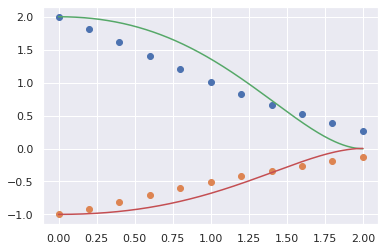

In [ ]:
plt.plot(t,lagaris(t,y0,params_opt).T,'o')
plt.plot(sol.t,sol.y.T)

Essayons avec une architecture différente:

In [ ]:
params_opt2 = init_params([1,20,10,10,2])
num_iters = 10000
params_opt2 = adam(grad(loss),params_opt2,num_iters = num_iters,callback=callback,step_size=0.001)

In [ ]:
params_opt2 = adam(grad(loss),params_opt2,num_iters = num_iters,callback=callback,step_size=10**-5)

Iteration  0/10000 loss 9.677432
Iteration  1000/10000 loss 9.343807
Iteration  2000/10000 loss 8.960960
Iteration  3000/10000 loss 8.748237
Iteration  4000/10000 loss 8.396860
Iteration  5000/10000 loss 8.166377
Iteration  6000/10000 loss 7.962034
Iteration  7000/10000 loss 7.779833
Iteration  8000/10000 loss 7.615094
Iteration  9000/10000 loss 7.467568


Même en changent l'architecture de notre réseau de neurones, on remarque quand même que la solution ne fait pas grand sens.

In [ ]:
plt.plot(t,lagaris(t,y0,params_opt2).T,'o')
plt.plot(sol.t,sol.y.T)

Voyons une solution qui fonctionne: Il s'agit ici d'une solution basée sur un réseau avec une seule couche cachée entraîné d'abord sur 100.000 itération d'adam avec un pas de $10^{-3}$ puis 1M sur le même algorithme avec un pas de $10^{-5}$. On obtient les paramètres suivants:

In [ ]:
params = [(np.array([[ 0.10813013,  0.03265201,  0.0788054 , -0.35538798,  0.03589739,
        -0.60314279,  0.62454724,  0.4211878 , -0.403067  ,  1.32026848]]), np.array([ 0.03531259,  0.19788998, -0.38759798,  0.51675693,  0.27541517,
       -0.14665625, -0.13679413,  0.09909085, -1.49035977,  0.14631405])), (np.array([[-1.10418515, -0.40108507],
       [-0.95666968,  0.71460646],
       [-0.13035987, -0.60564261],
       [-0.63593393, -0.1383721 ],
       [ 0.79156784,  0.31689273],
       [ 0.6440889 , -0.85852693],
       [-0.22480984, -0.1402638 ],
       [ 0.33676708, -0.48112532],
       [-0.65953446,  0.26315233],
       [ 0.45943416, -0.25922728]]), np.array([-0.16204617, -0.29357971]))]

On remarque ici que la solution, bien qu'assez proche est quand-même assez éronnée vers $t=2$.

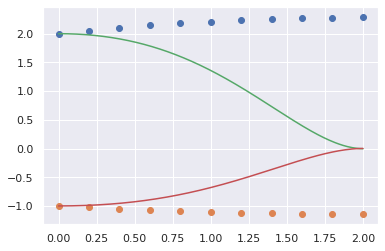

In [ ]:
plt.plot(t,lagaris(t,y0,params).T,'o')
plt.plot(sol.t,sol.y.T)

#Méthode d'optimisation différente: la méthode BFGS

Ici, nous nous proposons d'utiliser la méthode `minimize` de la bibliothèque `scipy` de python. Celle-ci nous permet d'utiliser des méthodes différentes de celles disponible dans le package `autograd`. On va utiliser une méthode de type Quasi-Newton (BFGS):

In [ ]:
from scipy.optimize import minimize
from autograd.misc.flatten import flatten

params=init_params([1,10,10,2])

On créé les fonctions qui vont nous servir à optimiser nos paramètres grâce à la fonction en question.

In [ ]:
def loss_opt(params):
  return cost(t,y0,params,f,a,np.tanh)
def loss_wrapper(params_flat):
  params=uflat(params_flat)
  return loss_opt(params)

def callback(params, iter, g):
  loss_calc[iter]=loss(params,iter)
  if iter%(num_iters/10) == 0 or iter == num_iters:
    print("Iteration  {:d}/{:d} loss {:.6f}".format(iter,num_iters,loss(params,iter)))

iteration = 1
iteration_max=5000
iteration_print=50
loss_scipy=[]
def print_loss(x):
  global iteration
  global iteration_print
  loss_cur=loss_wrapper(x)
  if iteration%iteration_print == 0:
    print("Loss : {:.6f} à l'itération {:d}".format(loss_cur,iteration))
  loss_scipy.append(loss_cur)
  iteration = iteration+1

In [ ]:
flat,uflat = flatten(params)
iteration = 1
iteration_max=5000
iteration_print=50
loss_scipy=[]

In [ ]:
opt=minimize(loss_wrapper,x0=np.array(flat),jac=grad(loss_wrapper),callback=print_loss, method = 'BFGS',options={'disp': True, 'maxiter': iteration_max})

Loss : 0.118315 à l'itération 50
Loss : 0.080744 à l'itération 100
Loss : 0.073056 à l'itération 150
Loss : 0.072486 à l'itération 200
Loss : 0.072322 à l'itération 250
Loss : 0.072141 à l'itération 300
Loss : 0.072043 à l'itération 350
Loss : 0.071989 à l'itération 400
Loss : 0.071938 à l'itération 450
Loss : 0.071904 à l'itération 500
Loss : 0.071856 à l'itération 550
Loss : 0.071372 à l'itération 600
Loss : 0.066309 à l'itération 650
Loss : 0.022260 à l'itération 700
Loss : 0.002414 à l'itération 750
Loss : 0.000557 à l'itération 800
Loss : 0.000229 à l'itération 850
Loss : 0.000155 à l'itération 900
Loss : 0.000079 à l'itération 950
Loss : 0.000042 à l'itération 1000
Loss : 0.000026 à l'itération 1050
Loss : 0.000019 à l'itération 1100
Loss : 0.000008 à l'itération 1150
Loss : 0.000004 à l'itération 1200
Loss : 0.000002 à l'itération 1250
         Current function value: 0.000001
         Iterations: 1280
         Function evaluations: 1495
         Gradient evaluations: 1483


Dans l'exemple ci-dessus, on remarque qu'on converge au bout de 1280 itérations pour une loss de $1 \cdot 10^{-5}$ ce qui rend l'optimisation de notre réseau beaucoup plus rapide.

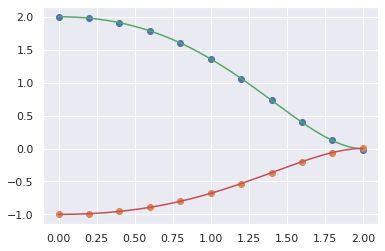

In [ ]:
params=uflat(opt.x)
plt.plot(t,lagaris(t,y0,params).T,'o')
plt.plot(sol.t,sol.y.T)

On peut aussi afficher l'erreur au cours de chaque itération:

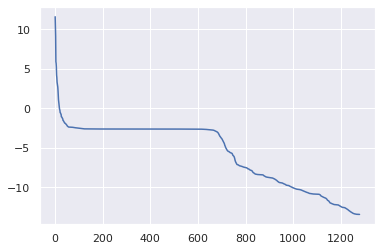

In [ ]:
plt.plot(np.log(loss_scipy))

#Références:

[Article originale, Flamant *et al.*](https://arxiv.org/pdf/2006.14372.pdf) \\
[Article connexe, Lagaris *et al.*](https://arxiv.org/pdf/physics/9705023.pdf) \\
[Librairie autograd de Google](https://github.com/HIPS/autograd) \\
[Code d'inspiration du solver](https://github.com/JiaweiZhuang/AM205_final/tree/2f6fdcec79d93a5480cc0cf05999a547df1bc522)